In [3]:
import os
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject
import geopandas as gpd
from rasterio.mask import mask
from rasterio.enums import Resampling

# Function to calculate pixel area in hectares
def pixel_area_in_hectares(lat, cell_size_degrees):
    ...

# Paths and input/output settings
input_raster_path ="E:\\India Validation\\Irrigated area\\SCIENTIFIC_DATA_IRRIGATION_MAP_2000_2015\\2000.tif"
# shapefile_path = "D:\\PhD_Udel\\MICRA_2015\\DOwnscaling\\NASAOCE\\Shapefile\\gadm41_BRA_1.shp"
output_directory = 'E:\\India Validation\\Irrigated area\\Resampled'

# Read shapefile
# gdf = gpd.read_file(shapefile_path)

# Processing the raster
with rasterio.open(input_raster_path) as src:
    # Define the new transform and width/height
    transform, width, height = calculate_default_transform(
        src.crs, src.crs, src.width, src.height, *src.bounds,
        resolution=(0.083333, 0.083333)  # 5 arc minutes in degrees
    )

    # Define the metadata for the new aggregated raster
    kwargs = src.meta.copy()
    kwargs.update({
        'transform': transform,
        'width': width,
        'height': height,
        'nodata': src.nodata
    })

    # Initialize an empty array for the aggregated data
    aggregated_data = np.zeros((height, width), dtype=src.meta['dtype'])
    
    # Reproject and aggregate the data using 'mean' reduction
    reproject(
        source=rasterio.band(src, 1),
        destination=aggregated_data,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs=src.crs,
        resampling=Resampling.max
    )

    # Save the aggregated raster
    with rasterio.open('E:\\India Validation\\Irrigated area\\Resampled\\2000.tif', 'w', **kwargs) as dst:
        dst.write(aggregated_data, 1)


In [8]:
import numpy as np
import rasterio
from rasterio.enums import Resampling
from rasterio import warp

# Paths to your input and output raster files
input_raster_path = "E:\\India Validation\\Irrigated area\\SCIENTIFIC_DATA_IRRIGATION_MAP_2000_2015\\2000.tif"
output_raster_path = 'E:\\India Validation\\Irrigated area\\Resampled\\2000_final.tif'

with rasterio.open(input_raster_path) as src:
    # Calculate the scale factor for the desired resolution
    scale_factor = src.res[0] / 0.083333333

    # Calculate the new shape
    new_shape = (src.count, 
                 int(src.height * scale_factor), 
                 int(src.width * scale_factor))

    # Initialize an array to hold the resampled data
    resampled_data = np.empty(shape=new_shape, dtype=src.meta['dtype'])

    # Update the affine transform for the resampled data
    new_transform = src.transform * src.transform.scale(
        (src.width / resampled_data.shape[-1]),
        (src.height / resampled_data.shape[-2])
    )

    # Reproject (resample) the data
    warp.reproject(
        source=rasterio.band(src, 1),
        destination=resampled_data[0],
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=new_transform,
        dst_crs=src.crs,
        resampling=Resampling.max
    )

    # Update metadata for the resampled raster
    resampled_meta = src.meta.copy()
    resampled_meta.update({
        'height': new_shape[1],
        'width': new_shape[2],
        'transform': new_transform
        # 'nodata': src.nodata - Uncomment if you have a nodata value to set
    })

    with rasterio.open(output_raster_path, 'w', **resampled_meta) as dst:
        # If resampled_data has an extra dimension, remove it
        if resampled_data.ndim == 3 and resampled_data.shape[0] == 1:
            resampled_data = resampled_data.squeeze()  # This should make it 2D
        dst.write(resampled_data, 1)

In [11]:
import rasterio
from rasterio.features import geometry_window
from affine import Affine
import numpy as np
from rasterio.features import geometry_window
from shapely.geometry import box
# Define the area of a single 30m pixel in square degrees
pixel_area = 0.0022170406 * 0.0022170406

# Paths to your input rasters
input_raster_path_30m = "E:\\India Validation\\Irrigated area\\SCIENTIFIC_DATA_IRRIGATION_MAP_2000_2015\\2000.tif"
input_raster_path_5arcmin = 'E:\\India Validation\\Irrigated area\\Area\\Area.tif'
output_raster_path ='E:\\India Validation\\Irrigated area\\Resampled\\2000_final.tif'

# Open both rasters
with rasterio.open(input_raster_path_30m) as src_30m, rasterio.open(input_raster_path_5arcmin) as src_5arcmin:
    
    # Ensure both rasters have the same CRS
    if src_30m.crs != src_5arcmin.crs:
        raise ValueError("CRS of both rasters does not match!")
    
    # Initialize an array for the aggregated results
    aggregated_data = np.zeros((src_5arcmin.height, src_5arcmin.width), dtype=np.float32)
    
    # Iterate over the 5 arc-minute grid cells
    for ji, window in src_5arcmin.block_windows(1):
        # Read the 5 arc-minute cell (zone)
        zone = src_5arcmin.read(window=window)
        
        bounds = src_5arcmin.window_bounds(window)
        geometry = box(*bounds)  # Create a shapely geometry from the bounds
        overlap_window = geometry_window(src_30m, [geometry.__geo_interface__])

        # Read data from the 30m raster within the overlap window
        data_30m = src_30m.read(window=overlap_window)
        
        # Perform the aggregation (sum)
        aggregated_value = data_30m.sum() * pixel_area
        
        # Place the aggregated value in the corresponding cell
        row_off, col_off = window.toranges()
        aggregated_data[row_off[0]:row_off[1], col_off[0]:col_off[1]] = aggregated_value
    
    # Save the aggregated data to a new raster file
    new_meta = src_5arcmin.meta.copy()
    new_meta.update(dtype=rasterio.float32)
    
    with rasterio.open(output_raster_path, 'w', **new_meta) as dst:
        dst.write(aggregated_data, 1)


In [ ]:
high_res = 0.0022170406  # High-resolution pixel size
five_arc_min = 0.083333333  # 5 arc-minute pixel size in degrees

# Calculate number of high-resolution pixels within one 5 arc-minute pixel
pixels_per_cell_x = int(five_arc_min / high_res)  # horizontally
pixels_per_cell_y = int(five_arc_min / high_res)  # vertically
import rasterio
import numpy as np
input_raster_path_30m = "E:\\India Validation\\Irrigated area\\SCIENTIFIC_DATA_IRRIGATION_MAP_2000_2015\\2000.tif"
input_raster_path_5arcmin = 'E:\\India Validation\\Irrigated area\\Area\\Area.tif'
output_raster_path ='E:\\India Validation\\Irrigated area\\Resampled\\2000_final.tif'

# Open the input high-resolution raster
with rasterio.open(input_raster_path) as src:
    
    # Calculate new dimensions
    new_width = src.width // pixels_per_cell_x
    new_height = src.height // pixels_per_cell_y
    
    # Initialize an empty array for the aggregated data
    aggregated_data = np.zeros((new_height, new_width), dtype=np.float32)
    # Pixel area in square degrees
    pixel_area = high_res * high_res

# Loop through the new raster dimensions
for y in range(new_height):
    for x in range(new_width):
        # Determine the high-resolution pixels that fall into the current low-resolution pixel
        window = rasterio.windows.Window(
            x * pixels_per_cell_x, 
            y * pixels_per_cell_y, 
            pixels_per_cell_x, 
            pixels_per_cell_y
        )
        
        # Read the data from the window
        data = src.read(1, window=window)
        
        # Aggregate the data (e.g., by summing it) and multiply by pixel area
        aggregated_value = data.sum() * pixel_area
        aggregated_data[y, x] = aggregated_value


In [19]:
import rasterio
import numpy as np
import math
high_res = 0.0022170406  # High-resolution pixel size in degrees
five_arc_min = 0.083333333  # 5 arc-minute pixel size in degrees

# Calculate number of high-resolution pixels within one 5 arc-minute pixel
pixels_per_cell_x = int(five_arc_min / high_res)  # horizontally
pixels_per_cell_y = int(five_arc_min / high_res)  # vertically

input_raster_path = "E:\\India Validation\\Irrigated area\\SCIENTIFIC_DATA_IRRIGATION_MAP_2000_2015\\2015.tif"
output_raster_path = 'E:\\India Validation\\Irrigated area\\Resampled\\2015_final.tif'

# Open the input high-resolution raster
with rasterio.open(input_raster_path) as src:
    
    # Calculate new dimensions
    new_width = src.width // pixels_per_cell_x
    new_height = src.height // pixels_per_cell_y
    
    # Initialize an empty array for the aggregated data
    aggregated_data = np.zeros((new_height, new_width), dtype=np.float32)
    
    # Pixel area in square degrees
    pixel_area = high_res * high_res
    
    # Loop through the new raster dimensions
    for y in range(new_height):
        for x in range(new_width):
            # Determine the high-resolution pixels that fall into the current low-resolution pixel
            window = rasterio.windows.Window(
                x * pixels_per_cell_x, 
                y * pixels_per_cell_y, 
                pixels_per_cell_x, 
                pixels_per_cell_y
            )
            
            # Read the data from the window
            data = src.read(1, window=window)
            
            # Aggregate the data (e.g., by summing it) and multiply by pixel area
            aggregated_value = data.sum() * pixel_area
            aggregated_data[y, x] = aggregated_value

    # Define new transform for the aggregated data
    new_transform = src.transform * src.transform.scale(
        (src.width / aggregated_data.shape[1]),
        (src.height / aggregated_data.shape[0])
    )

    # Define new metadata for the output raster
    new_meta = src.meta.copy()
    new_meta.update({
        "driver": "GTiff",
        "height": new_height,
        "width": new_width,
        "transform": new_transform,
        "dtype": "float32"
    })
    
    # Write the aggregated data to a new raster file
    with rasterio.open(output_raster_path, 'w', **new_meta) as dst:
        dst.write(aggregated_data, 1)


In [26]:
import rasterio
import numpy as np
import math
# Define the input and output paths
input_raster_path = "E:\\India Validation\\Irrigated area\\SCIENTIFIC_DATA_IRRIGATION_MAP_2000_2015\\2000.tif"
output_raster_path = 'E:\\India Validation\\Irrigated area\\Resampled\\2000_final.tif'
# Function to convert square degrees to hectares at a specific latitude
def square_degrees_to_hectares(width_deg, height_deg, latitude):
    # Earth's radius in kilometers at the equator
    earth_radius_km = 6371.0
    
    # Convert latitude to radians for the cosine function
    lat_rad = math.radians(latitude)
    
    # Area calculation assuming a spheroidal Earth
    area_km2 = ((width_deg * (math.pi/180) * earth_radius_km * np.cos(lat_rad)) *
                (height_deg * (math.pi/180) * earth_radius_km))
    
    # Convert area from square kilometers to hectares (1 hectare = 0.01 km²)
    return area_km2 * 100
#  High-resolution pixel size in degrees
high_res = 0.0022170406
# 5 arc-minute pixel size in degrees
five_arc_min = 0.083333333

# Calculate the number of high-resolution pixels within one 5 arc-minute pixel
pixels_per_cell_x = int(five_arc_min / high_res)  # horizontally
pixels_per_cell_y = int(five_arc_min / high_res)  # vertically

# Open the high-resolution input raster
with rasterio.open(input_raster_path) as src:

    # Read the input raster's profile
    profile = src.profile

    # Calculate new dimensions
    new_width = src.width // pixels_per_cell_x
    new_height = src.height // pixels_per_cell_y
    
    # Initialize an empty array for the aggregated data
    aggregated_data = np.zeros((new_height, new_width), dtype=np.float32)
    
    # Loop through the new raster dimensions
    for y in range(new_height):
        for x in range(new_width):
            # Get the latitude at the center of the current window
            center_y = (y + 0.5) * pixels_per_cell_y * high_res + src.bounds.bottom
            # Convert the pixel area from square degrees to hectares
            pixel_area_hectares = square_degrees_to_hectares(high_res, high_res, center_y)
            
            # Determine the high-resolution pixels that fall into the current low-resolution pixel
            window = rasterio.windows.Window(x * pixels_per_cell_x, 
                                             y * pixels_per_cell_y, 
                                             pixels_per_cell_x, 
                                             pixels_per_cell_y)
            
            # Read the data from the window
            data = src.read(1, window=window)
            
            # Aggregate the data by summing and convert to hectares
            aggregated_value = data.sum() * pixel_area_hectares
            aggregated_data[y, x] = aggregated_value

    # Update the transform and metadata for writing the output raster
    transform = src.transform * src.transform.scale(
        (src.width / aggregated_data.shape[1]),
        (src.height / aggregated_data.shape[0])
    )
    profile.update({
        'dtype': 'float32',
        'height': new_height,
        'width': new_width,
        'transform': transform
    })

    # Write the aggregated data to the output raster
    with rasterio.open(output_raster_path, 'w', **profile) as dst:
        dst.write(aggregated_data, 1)

In [49]:
import os
import rasterio
import numpy as np
from rasterio.enums import Resampling

# Function to clean raster data
def clean_raster_data(raster_data, nodata_value=0):
    """
    Replace NaN values and values outside a specified range with a nodata_value.
    """
    # Replace NaN values with nodata_value
    raster_data_cleaned = np.where(np.isnan(raster_data), nodata_value, raster_data)
    # Replace values outside the valid data range with nodata_value
    raster_data_cleaned = np.where((raster_data_cleaned < 0.1) | (raster_data_cleaned > 18000), nodata_value, raster_data_cleaned)
    return raster_data_cleaned

# Function to resample and adjust raster dimensions and projection
def resample_and_adjust(input_path, output_path, target_profile):
    with rasterio.open(input_path) as src:
        # Read the data and resample to match target profile
        data = src.read(
            out_shape=(src.count, target_profile['height'], target_profile['width']),
            resampling=Resampling.bilinear
        )
        
        # Update the profile to match target profile
        profile = src.profile.copy()
        profile.update(target_profile)
        
        # Clean the raster data
        data_cleaned = clean_raster_data(data)
        
        # Write the adjusted and cleaned raster to output path
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(data_cleaned)

# Paths to MIRCA-OS and GEOGLAM_Crop folders
mirca_os_folder = 'E:\\India Validation\\Irrigated area\\MIRCA-OS'
geoglam_crop_folder = 'E:\\India Validation\\Irrigated area\\GEOGLAM_Crop'
output_folder = 'E:\\India Validation\\Irrigated area\\CROP ALL'

#  Loop over files in GEOGLAM_Crop folder
for root, dirs, files in os.walk(geoglam_crop_folder):
    for file in files:
        # Check if file is a raster
        if file.endswith('.tif'):
            geoglam_crop_path = os.path.join(root, file)
            crop_name = os.path.splitext(file)[0]  # Extract crop name from file name
            
            # Find corresponding file in MIRCA-OS folder
            mirca_os_path = os.path.join(mirca_os_folder, file)
            
            # Check if corresponding file exists in MIRCA-OS folder
            if os.path.exists(mirca_os_path):
                # Read target profile from MIRCA-OS raster
                with rasterio.open(mirca_os_path) as src:
                    target_profile = src.profile
                
                # Adjust and resample GEOGLAM_Crop raster to match target profile
                output_path = os.path.join(output_folder, file)
                resample_and_adjust(geoglam_crop_path, output_path, target_profile)
                
                print(f"Adjusted, resampled, and cleaned {file} and saved to {output_path}")
            else:
                print(f"No corresponding file found for {file} in MIRCA-OS folder")

Adjusted, resampled, and cleaned Maize.tif and saved to E:\India Validation\Irrigated area\CROP ALL\Maize.tif
Adjusted, resampled, and cleaned Rice.tif and saved to E:\India Validation\Irrigated area\CROP ALL\Rice.tif
Adjusted, resampled, and cleaned Soybeans.tif and saved to E:\India Validation\Irrigated area\CROP ALL\Soybeans.tif
Adjusted, resampled, and cleaned Wheat.tif and saved to E:\India Validation\Irrigated area\CROP ALL\Wheat.tif


In [33]:
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Paths to your raster files
irrigated_area_raster_path = "E:\\India Validation\\Irrigated area\\Resampled\\2015_final.tif"
crop_area_raster_path = "E:\\India Validation\\Irrigated area\\GEOGLAM\\Wheat.tif"
output_raster_path = "E:\\India Validation\\Irrigated area\\GEOGLAM_Crop\\Wheat.tif"

# Open the crop area raster to get its spatial characteristics
with rasterio.open(crop_area_raster_path) as crop_src:
    crop_data = crop_src.read(1)  # Read the first band
    crop_meta = crop_src.meta  # We'll use this metadata as the target for reprojection
    crop_transform = crop_src.transform
    crop_bounds = crop_src.bounds

# Open the irrigated area raster to reproject it to match the crop area raster
with rasterio.open(irrigated_area_raster_path) as irrigated_src:
    irrigated_meta = irrigated_src.meta
    irrigated_transform = irrigated_src.transform
    irrigated_crs = irrigated_meta['crs']
    irrigated_bounds = irrigated_src.bounds

    # Calculate the transformation needed to match the crop area raster
    transform, width, height = calculate_default_transform(
        irrigated_crs, crop_meta['crs'], crop_meta['width'], crop_meta['height'], *crop_bounds
    )
    reprojected_irrigated_data = np.empty(shape=(height, width), dtype=np.float32)

    # Reproject the irrigated area raster
    reproject(
        source=rasterio.band(irrigated_src, 1),
        destination=reprojected_irrigated_data,
        src_transform=irrigated_transform,
        src_crs=irrigated_crs,
        dst_transform=transform,
        dst_crs=crop_meta['crs'],
        resampling=Resampling.nearest
    )

# Perform the conditional check
output_data = np.where((reprojected_irrigated_data > 0) & (crop_data > 0), crop_data, 0)

# Use the metadata from the crop area raster for the output raster
output_meta = crop_meta.copy()
output_meta.update(dtype='float32')

# Save the output data to a new TIFF file
with rasterio.open(output_raster_path, 'w', **output_meta) as out_dst:
    out_dst.write(output_data, 1)


C:\Users\endal\AppData\Local\Temp\ipykernel_81604\2549053007.py:186: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_xticklabels(labels, fontsize=14, fontname=title_font)
C:\Users\endal\AppData\Local\Temp\ipykernel_81604\2549053007.py:187: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_yticklabels(ax_bar.get_yticks(), fontsize=14, fontname=title_font)


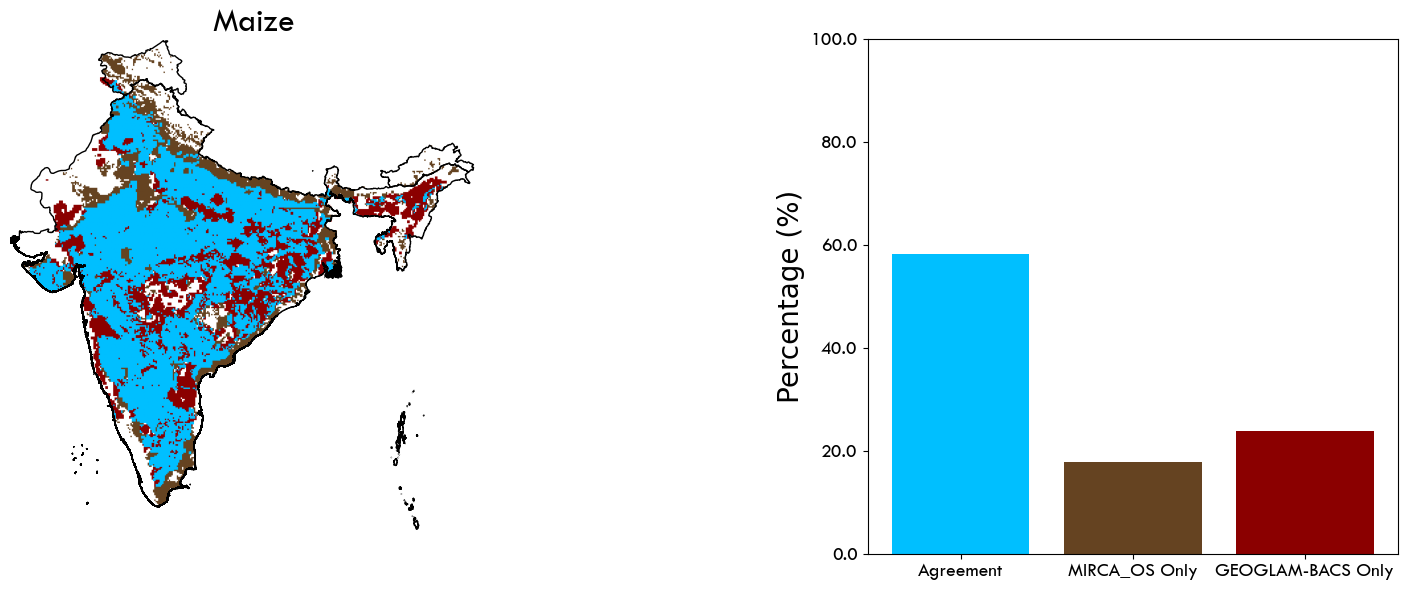

C:\Users\endal\AppData\Local\Temp\ipykernel_81604\2549053007.py:186: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_xticklabels(labels, fontsize=14, fontname=title_font)
C:\Users\endal\AppData\Local\Temp\ipykernel_81604\2549053007.py:187: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_yticklabels(ax_bar.get_yticks(), fontsize=14, fontname=title_font)


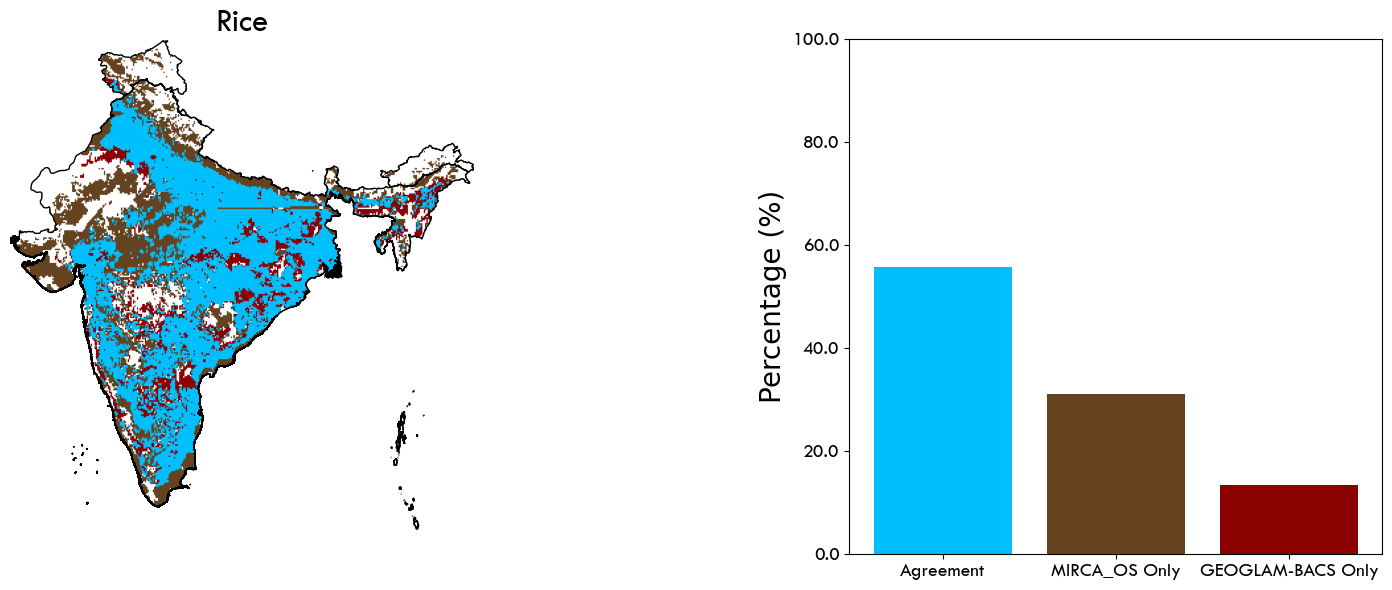

C:\Users\endal\AppData\Local\Temp\ipykernel_81604\2549053007.py:186: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_xticklabels(labels, fontsize=14, fontname=title_font)
C:\Users\endal\AppData\Local\Temp\ipykernel_81604\2549053007.py:187: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_yticklabels(ax_bar.get_yticks(), fontsize=14, fontname=title_font)


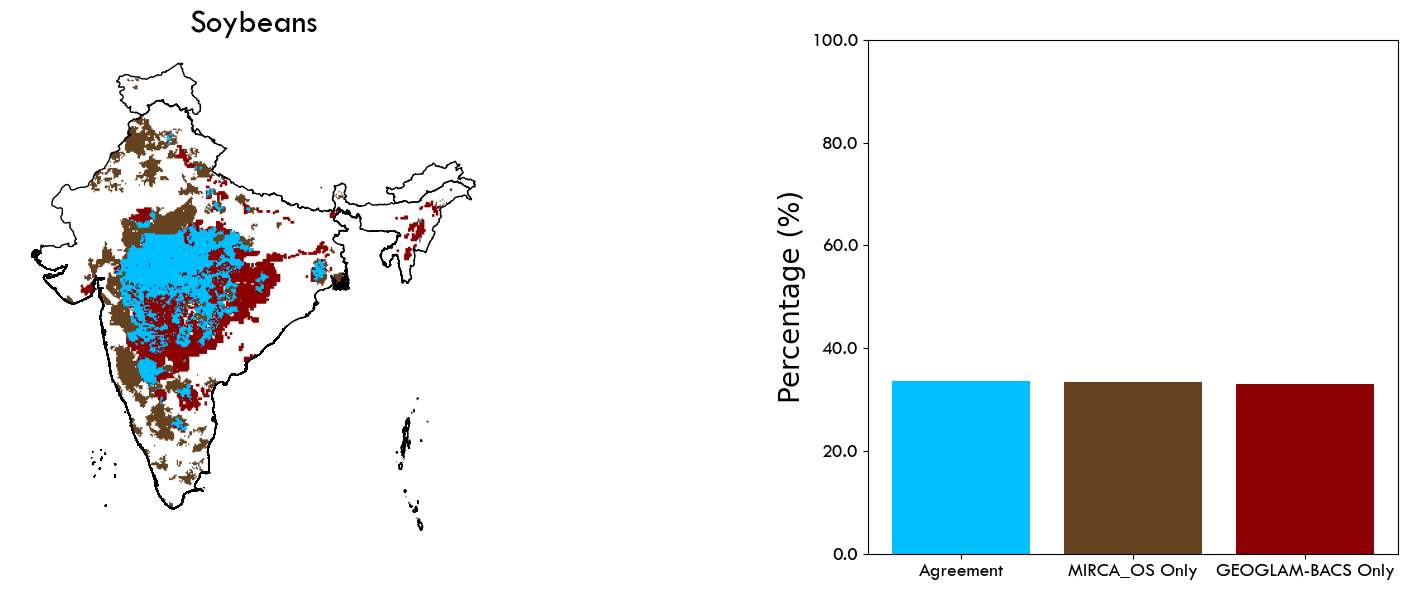

C:\Users\endal\AppData\Local\Temp\ipykernel_81604\2549053007.py:186: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_xticklabels(labels, fontsize=14, fontname=title_font)
C:\Users\endal\AppData\Local\Temp\ipykernel_81604\2549053007.py:187: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_yticklabels(ax_bar.get_yticks(), fontsize=14, fontname=title_font)


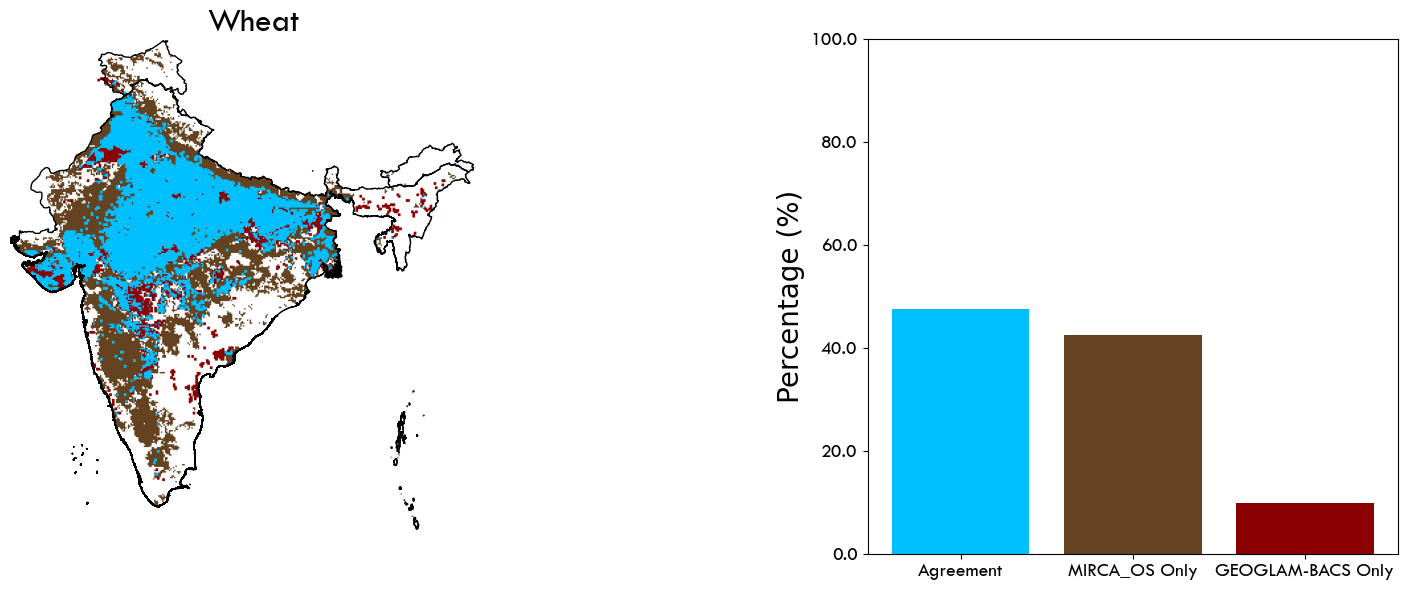

In [2]:
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.patches as mpatches
from matplotlib import font_manager
from rasterio.enums import Resampling
# Define new colors for the plot
darker_blue = (0, 191/255, 255/255)  # Dark Blue for agreement
light_blue = (101/255, 67/255, 33/255)  # Light Blue for MIRCA-OS Only
dark_red = (139/255, 0, 0)  # Dark Red for MIRCA2000 Only

# Check if 'Tw Cen MT' font is available
if 'Tw Cen MT' not in [f.name for f in font_manager.fontManager.ttflist]:
    print('The "Tw Cen MT" font is not available on your system. Please use an available font or install "Tw Cen MT".')
    title_font = 'sans-serif'
else:
    title_font = 'Tw Cen MT'

# Function to read raster data
# Update the read_raster function to return the CRS as well
def read_raster(file_path):
    with rasterio.open(file_path) as src:
        data = src.read(1)
        transform = src.transform
        crs = src.crs
        return data, transform, crs

# Function to compare rasters and return presence/absence data
def compare_rasters(raster1, raster2):
    agree = (raster1 > 0) & (raster2 > 0)
    mirca_os_only = (raster1 > 0) & (raster2 == 0)
    mirca_2000_only = (raster1 == 0) & (raster2 > 0)
    return agree, mirca_os_only, mirca_2000_only


def resample_raster(src_raster_path, match_raster_path, resampled_raster_path):
    with rasterio.open(match_raster_path) as match_src:
        match_transform = match_src.transform
        match_width = match_src.width
        match_height = match_src.height

        with rasterio.open(src_raster_path) as src:
            # Resample the source raster to match
            data = src.read(
                out_shape=(
                    src.count,
                    match_height,
                    match_width
                ),
                resampling=Resampling.bilinear
            )

            # Adjust the transform accordingly
            transform = match_src.transform

            profile = src.profile
            profile.update({
                'transform': transform,
                'width': match_width,
                'height': match_height
            })

            with rasterio.open(resampled_raster_path, 'w', **profile) as dst:
                dst.write(data)

# Function to get the extent of a raster from its transform
def get_extent(transform, width, height):
    left = transform[2]
    top = transform[5]
    right = left + transform[0] * width
    bottom = top + transform[4] * height
    return (left, right, bottom, top)

# Function to clean raster data
import numpy as np

def clean_raster_data(raster_data, nodata_value=0):
    """
    Replace NaN values and values outside a specified range with a nodata_value.
    """
    # Replace NaN values with nodata_value
    raster_data_cleaned = np.where(np.isnan(raster_data), nodata_value, raster_data)
    # Replace values outside the valid data range with nodata_value
    raster_data_cleaned = np.where((raster_data_cleaned < 0.1) | (raster_data_cleaned > 18000), nodata_value, raster_data_cleaned)
    return raster_data_cleaned

# # New function to calculate agreement percentages for the bar chart based on counts
def calculate_percentages(agree, mirca_os_only, mirca_2000_only):
    agree_count = np.sum(agree)
    mirca_os_only_count = np.sum(mirca_os_only)
    mirca_2000_only_count = np.sum(mirca_2000_only)
    total_valid_pixels = agree_count + mirca_os_only_count + mirca_2000_only_count
    agree_pct = (agree_count / total_valid_pixels) * 100 if total_valid_pixels > 0 else 0
    mirca_os_only_pct = (mirca_os_only_count / total_valid_pixels) * 100 if total_valid_pixels > 0 else 0
    mirca_2000_only_pct = (mirca_2000_only_count / total_valid_pixels) * 100 if total_valid_pixels > 0 else 0
    return agree_pct, mirca_os_only_pct, mirca_2000_only_pct
# Function to reproject a raster
def reproject_raster(src_path, dst_crs, dst_path):
    with rasterio.open(src_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(dst_path, 'w', **kwargs) as dst:
            reproject(
                source=rasterio.band(src, 1),
                destination=rasterio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
# Load the shapefile
shapefile_path = "D:\\PhD_Udel\\MICRA_2015\\Asia\\India\\Shape File\\Global\\India\\gadm41_IND_0.shp"
world = gpd.read_file(shapefile_path)

# Directories for raster data
base_dir_os = "E:\\India Validation\\Irrigated area\\MIRCA-OS"
base_dir_2000 ="E:\\India Validation\\Irrigated area\\CROP ALL\\All"
# Crop names
crops = ["Maize","Rice","Soybeans", "Wheat"]
# Set up the plot dimensions and resolution
figsize = (10, 6)
dpi = 100  # Adjust the dpi to your preference for resolution

# Create a plot for each crop
# Create a plot for each crop
for i, crop in enumerate(crops):
    fig, (ax_map, ax_bar) = plt.subplots(1, 2, figsize=(20, 6),
                                          gridspec_kw={'width_ratios': [3, 1]})

    # Read the rasters and their CRS
    raster1_data, raster1_transform, raster1_crs = read_raster(f'{base_dir_os}/{crop}.tif')
    raster2_data, raster2_transform, raster2_crs = read_raster(f'{base_dir_2000}/{crop}.tif')

    # Clean rasters
    raster1_data = clean_raster_data(raster1_data)
    raster2_data = clean_raster_data(raster2_data)

    # If the shapes of the rasters do not match, resample one raster to the other's shape
    if raster1_data.shape != raster2_data.shape:
        # Choose which raster to resample, here we resample raster2 to match raster1's shape
        resampled_raster2_path = f'{base_dir_2000}/{crop}_resampled.tif'
        resample_raster(f'{base_dir_2000}/{crop}.tif', f'{base_dir_os}/{crop}.tif', resampled_raster2_path)
        # Read the resampled raster
        raster2_data, raster2_transform, raster2_crs = read_raster(resampled_raster2_path)

    # Compare rasters now that the shapes match
    agree, mirca_os_only, mirca_2000_only = compare_rasters(raster1_data, raster2_data)

    # Calculate percentages for the bar chart
    agree_pct, mirca_os_only_pct, mirca_2000_only_pct = calculate_percentages(agree, mirca_os_only, mirca_2000_only)

    # Initialize combined RGB array with the correct shape
    combined_rgb = np.ones((raster1_data.shape[0], raster1_data.shape[1], 3))

    # Apply new colors based on the comparison
    combined_rgb[agree] = darker_blue
    combined_rgb[mirca_os_only] = light_blue
    combined_rgb[mirca_2000_only] = dark_red
    # Plot map
    extent = get_extent(raster1_transform, raster1_data.shape[1], raster1_data.shape[0])
    ax_map.imshow(combined_rgb, extent=extent)
#     ax_map.imshow(combined_rgb, extent=extent)
    ax_map.set_title(f'{crop}', fontsize=24, fontname=title_font)
    ax_map.set_frame_on(False)
    world.boundary.plot(ax=ax_map, linewidth=1, edgecolor='black')

    # Remove x and y ticks
    ax_map.set_xticks([])
    ax_map.set_yticks([])

#  # Plot bar chart on ax_bar
    labels = ['Agreement', 'MIRCA_OS Only', 'GEOGLAM-BACS Only']
    percentages = [agree_pct, mirca_os_only_pct, mirca_2000_only_pct]
    ax_bar.bar(labels, percentages, color=[darker_blue, light_blue, dark_red])
    ax_bar.set_ylabel('Percentage (%)',  fontsize=20)
    ax_bar.set_ylim(0, 100)
    ax_bar.set_xticklabels(labels, fontsize=14, fontname=title_font) 
    ax_bar.set_yticklabels(ax_bar.get_yticks(), fontsize=14, fontname=title_font)
#     if i == len(crops) - 1:  # Check if this is the last plot
#         legend_elements = [
#             mpatches.Patch(color=darker_blue, label='Agreement'),
#             mpatches.Patch(color=light_blue, label='MIRCA-OS Only'),
#             mpatches.Patch(color=dark_red, label='GEOGLAM-BACS Only')
#         ]
#         # Adjust bbox_to_anchor to ensure the legend is inside the figure
#         ax_map.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(1, 0),
#                       ncol=1, borderaxespad=0., fontsize=24)
    # Adjust subplot parameters and layout
    plt.subplots_adjust(wspace=0.3)
    plt.tight_layout()

    # Save the figure with both the map and bar chart for the current crop
    plt.savefig(f'E:\\India Validation\\Irrigated area\\Maps New\\{crop}_2015.png', bbox_inches='tight')
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\India Validation\\Irrigated area\\Maps\\1_ir.png'

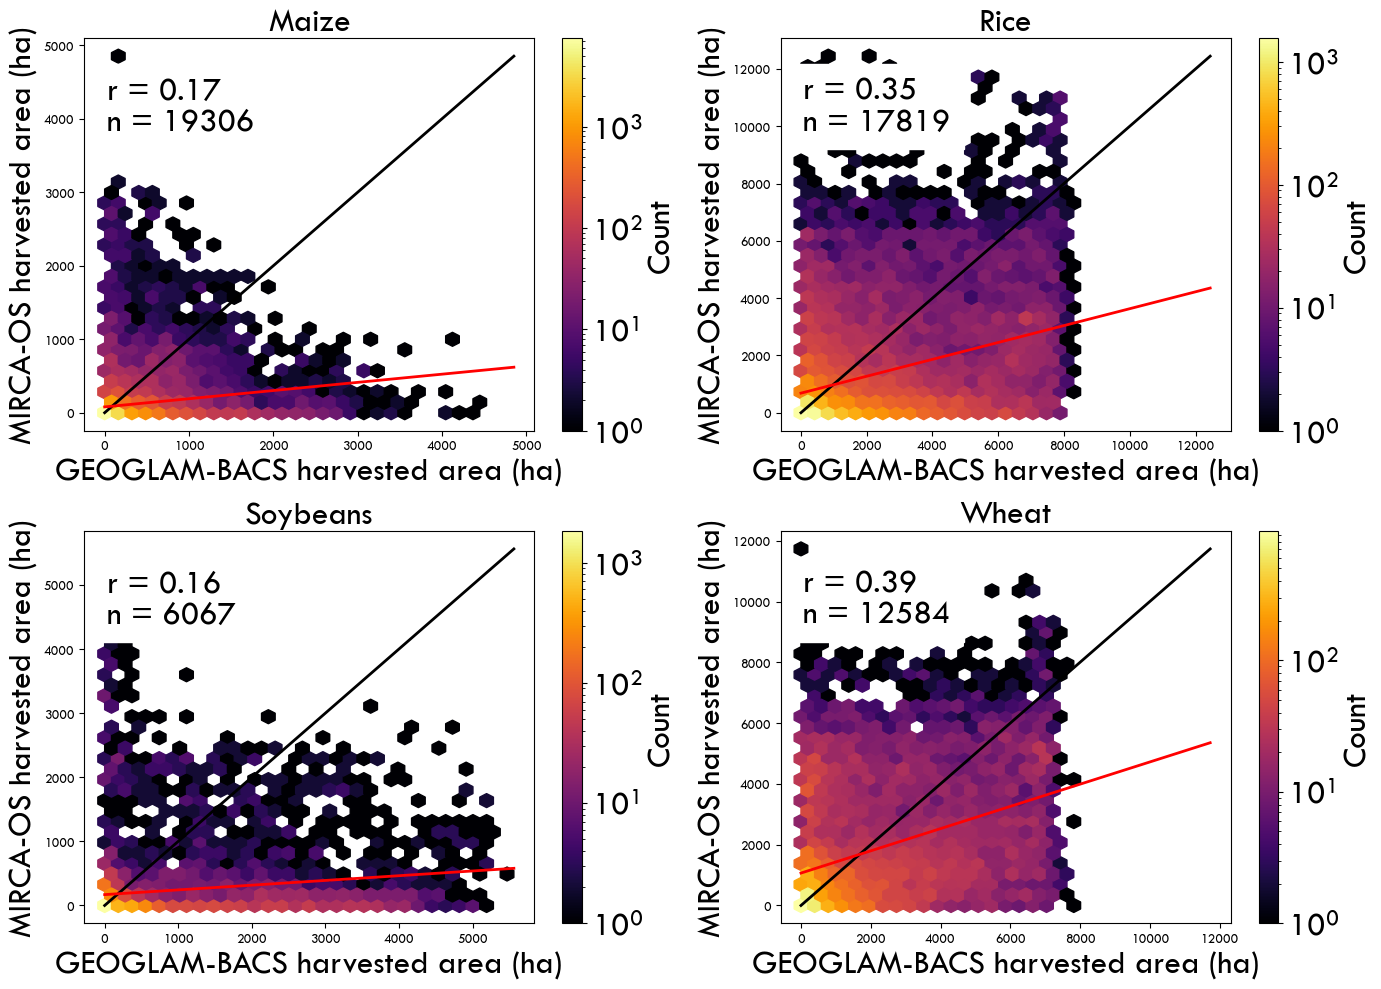

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from scipy.stats import linregress, pearsonr

# Set the font family globally for all plots
plt.rcParams['font.family'] = 'Tw Cen MT'

# Define the base font size
font_size = 24

# Define the clean_raster_data function
def clean_raster_data(raster_data):
    """
    Replace extreme negative and positive values in raster data with zero while keeping NaN values unchanged.

    Parameters:
    raster_data (np.array): The input raster data as a NumPy array.

    Returns:
    np.array: The raster data with extreme values set to zero.
    """
    return np.where((raster_data < 0) | (raster_data == -1e+38), 0, raster_data)

# Define the plot_scatter_and_regression function
def plot_scatter_and_regression(ax, x, y, crop_name):
    # Ensure that we remove no_data_values from the data before plotting
    mask = (x != no_data_value) & (y != no_data_value)
    x = x[mask]
    y = y[mask]
    
    # Calculate the Pearson correlation coefficient
    r, _ = pearsonr(x, y)

    # Calculate the common range for x and y axes
    common_min = min(np.nanmin(x), np.nanmin(y))
    common_max = max(np.nanmax(x), np.nanmax(y))
    
    # Create a hexbin plot 
    hb = ax.hexbin(x, y, gridsize=30, cmap='inferno', bins='log', extent=(common_min, common_max, common_min, common_max))
#     hb = ax.hexbin(x, y, gridsize=50, cmap='plasma', bins='log', )
    cbar = ax.figure.colorbar(hb, ax=ax, label='Count')
    cbar.ax.tick_params(labelsize=font_size)  # Set the fontsize for colorbar ticks
    cbar.set_label('Count', size=font_size)  # Set the fontsize for colorbar label

    # Add the 1:1 line
    ax.plot([common_min, common_max], [common_min, common_max], color='black', linestyle='-', linewidth=2)

    # Perform linear regression
    slope, intercept = linregress(x, y)[:2]
    ax.plot([common_min, common_max], [intercept + slope * common_min, intercept + slope * common_max], color='red', linewidth=2)

    # Add text annotation in the plot
    text_x = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
    text_y = ax.get_ylim()[1] - (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.1
    ax.text(text_x, text_y, f'r = {r:.2f}\nn = {len(x)}', color='black', ha='left', va='top', backgroundcolor='white', fontsize=font_size)

    # Set axis labels and title
    ax.set_xlabel('GEOGLAM-BACS harvested area (ha)', fontsize=font_size)
    ax.set_ylabel('MIRCA-OS harvested area (ha)', fontsize=font_size)
    ax.set_title(f'{crop_name}', fontsize=font_size)


# Define no_data_value
no_data_value = 0

# Define the paths to the directories
folder1 = "E:\\India Validation\\Irrigated area\\CROP ALL\\All"
folder2 =  "E:\\India Validation\\Irrigated area\\MIRCA-OS"

# Create a 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.ravel()

# List the raster files
rasters1 = {os.path.splitext(file)[0]: os.path.join(folder1, file) for file in os.listdir(folder1) if file.endswith('.tif')}
rasters2 = {os.path.splitext(file)[0]: os.path.join(folder2, file) for file in os.listdir(folder2) if file.endswith('.tif')}

# Iterate over the rasters
# Iterate over the rasters
for crop_name, raster_path1 in rasters1.items():
    raster_path2 = rasters2.get(crop_name)
    if raster_path2:
        with rasterio.open(raster_path1) as src1, rasterio.open(raster_path2) as src2:
            # Read the data and apply the cleaning function
            data1 = clean_raster_data(src1.read(1))
            data2 = clean_raster_data(src2.read(1))

            # Flatten the arrays to create a 1D array for each
            data1 = data1.flatten()
            data2 = data2.flatten()

            # Check if there is any valid data left after cleaning
            if np.all(data1 == no_data_value) or np.all(data2 == no_data_value):
                print(f"All data for {crop_name} are no-data after cleaning.")
                continue

            # Find the next available subplot
            ax = next((ax for ax in axs if not ax.has_data()), None)
            if ax is None:
                print("No more empty subplots available.")
                break

            # Plot the data on the corresponding subplot axis
            plot_scatter_and_regression(ax, data1, data2, crop_name)

# Adjust the layout and display the plot
plt.tight_layout()
plt.savefig(f'E:\\India Validation\\Irrigated area\\Maps\\1_ir.png', bbox_inches='tight')
plt.show()
